# Time Evolution
Using what we learned from the effective Hamiltonian, it is now time to compute the density matrix. Recall that the density matrix (linearly mapped to a vector) absent any noise is given by:
$$
    \newcommand{ket}[1]{\left|#1\right\rangle}
    \newcommand{bra}[1]{\left\langle#1\right|}
    \vec{\rho}(t) = (R\otimes R)\left( \sum_{jk}e^{-i\omega_{jk}t}\ket{j}\bra{j}\otimes \ket{k}\bra{k} \right) (R^{-1}\otimes R^{-1})\vec{\rho}(0)
$$
with $R$ the eigenvector matrix and $\omega_{jk}$ the eigenvalues of the system.

## Single Donor, Single Mode-Single Photon
Again, the Hamiltonian in the single qubit case is:
$$
H = \hbar \omega_c a^\dagger a + \sum_j E_j \ket{j}\bra{j} + \frac{1}{2}g_c(a+a^\dagger)(1+Z)
$$
where $Z$ is defined as: 
$$
Z = \sum_{jk} z_{jk}\sigma_j\tau_j 
$$
$\omega_c$ is the cavity energy and $g_c$ is the photon-charge coupling strength. The eigenenergies up to second order in perturbation theory in the single qubit case are:
$$
        \begin{align}
            E_0 &= \frac{1}{2}(-\omega_0-\omega_B)-\frac{A}{8} \left(1-\cos \eta\right)-\frac{\Delta\omega_B}{4}\left(1+\cos \eta\right)-\frac{A^2}{16\omega_B}\left((1-\cos\eta)^2+\sin^2\eta(\frac{\omega_B}{4\omega_0}+\frac{\omega_B}{\omega_0+\omega_B}-\frac{\omega_B\Delta\omega_B}{A\omega_0}+\frac{\omega_B\Delta\omega_B^2}{A^2\omega_0})\right)\\
            E_1 &= \frac{1}{2}(-\omega_0+\omega_B)-\frac{A}{8} \left(1-\cos \eta\right)+\frac{\Delta\omega_B}{4}\left(1+\cos \eta\right)-\frac{A^2}{16\omega_B}\left(-(1-\cos\eta)^2+\sin^2\eta(\frac{\omega_B}{4\omega_0}+\frac{\omega_B}{\omega_0-\omega_B}+\frac{\omega_B\Delta\omega_B}{A\omega_0}+\frac{\omega_B\Delta\omega_B^2}{A^2\omega_0})\right) \\
            E_2 &= \frac{1}{2}( \omega_0-\omega_B)-\frac{A}{8} \left(1+\cos \eta\right)-\frac{\Delta\omega_B}{4}\left(1-\cos \eta\right)-\frac{A^2}{16\omega_B}\left((1+\cos\eta)^2+\sin^2\eta(-\frac{\omega_B}{4\omega_0}-\frac{\omega_B}{\omega_0-\omega_B}+\frac{\omega_B\Delta\omega_B}{A\omega_0}-\frac{\omega_B\Delta\omega_B^2}{A^2\omega_0})\right) \\
            E_3 &= \frac{1}{2}( \omega_0+\omega_B)-\frac{A}{8} \left(1+\cos \eta\right)+\frac{\Delta\omega_B}{4}\left(1-\cos \eta\right)-\frac{A^2}{16\omega_B}\left(-(1+\cos\eta)^2+\sin^2\eta(-\frac{\omega_B}{4\omega_0}-\frac{\omega_B}{\omega_0+\omega_B}-\frac{\omega_B\Delta\omega_B}{A\omega_0}-\frac{\omega_B\Delta\omega_B^2}{A^2\omega_0})\right)
        \end{align}
$$
and the coefficients of $Z$ are
$$
        \begin{align}
            z_{01} &= -A\omega_0\Delta\omega_B\cos\eta\sin^2\eta/4\omega_B(\omega_0^2-\omega_B^2) \\
            z_{03} &= A^2\omega_0^3\cos\eta\sin^2\eta/4\omega_B(\omega_0^2-\omega_B^2)^2 \\
            z_{10} &= \sin\eta + A\cos\eta\sin\eta/4\omega_0 \\
            z_{11} &= -A\omega_0\cos\eta\sin\eta/2(\omega_0^2-\omega_B^2) \\
            z_{13} &= -\Delta\omega_B\cos\eta\sin\eta/2\omega_0 \\
            z_{22} &= -A\omega_0^2\cos\eta\sin\eta/2\omega_B(\omega_0^2-\omega_B^2) \\
            z_{30} &= \cos\eta - A\sin^2\eta/4\omega_0 \\
            z_{31} &= A\omega_0\sin^2\eta/2(\omega_0^2-\omega_B^2) \\
            z_{33} &= \Delta\omega_B\sin^2\eta/2\omega_0 
        \end{align}
$$

In [1]:
# Import necessary libraries
import numpy as np
import pandas as pd
from scipy.linalg import expm
import matplotlib
matplotlib.use("Agg")
import datetime

import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as colors
from matplotlib import rc
import matplotlib.ticker as ticker

%matplotlib inline
# Import Pauli Matrices and System Constants
from DensityMatrix_TimeEvolution import *
import Noise.Pink as Noise

Computing the density matrix element amounts to computing 3 matrices:
$$ R\otimes R $$
$$ \sum_{jk}e^{-i\omega_{jk}t}\ket{j}\bra{j}\otimes \ket{k}\bra{k} $$
$$ R^{-1}\otimes R^{-1} $$
and multiplying them into the initial density matrix.

We also don't care so much about the photon number so we should trace out that degree of freedom.
$$
    \rho_{\textrm{ff}}(t) = \textrm{Tr}_c(\rho(t))
$$

In [2]:
# Single Qubit
Nd = 1  # Number of donor qubits
Nq = 4
Nm = 1
Np = 1

initial_cavity_state = np.zeros(((Np+1)**Nm,1))
initial_cavity_state[0,:] = 1
initial_flipflop_state = np.array([[0,1,0,0]]).transpose()
initial_total_state = np.kron(initial_cavity_state,initial_flipflop_state)

wc = 5.0 # GHz, TODO: Find actual value for this
gc = 0.05 # GHz, TODO: Find actual value for this
parameters_qubits = []
for _ in np.arange(Nd):
    parameters_qubits.append({'Vt':11.4, 'wB':11.3, 'eps':0})
parameters_cavity = []
for _ in np.arange(Nm):
    parameters_cavity.append({'wc': wc , 'gc':gc})

system = FlipFlopSystem(Nm, Np, parameters_cavity, Nd, parameters_qubits)

N_t = 250
T_Max = 50
t, rho = computeDensityMatrixZeroNoise(system, initial_total_state, T_Max, N_t)
rho_cav, rho_ff = partialTraceSystem(rho, Np, Nd, Nq, Nm)
print(rho_ff.shape)
print(rho_cav.shape)

(250, 4, 4)
(250, 2, 2)


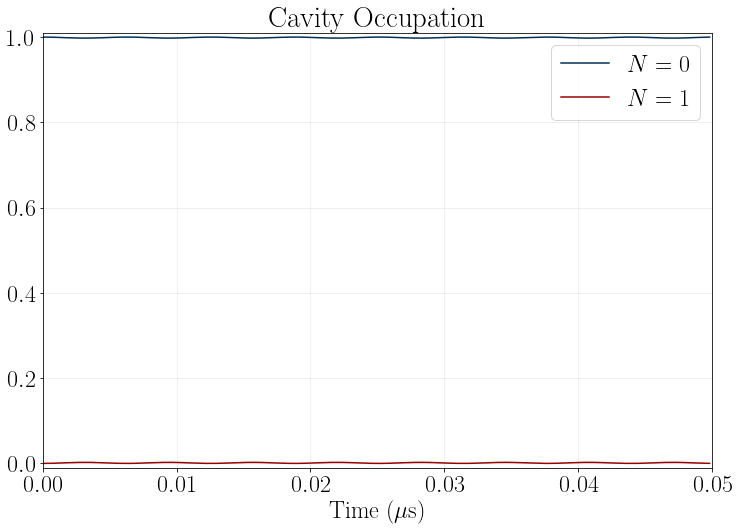

In [7]:
plt.rc("font", size=24)
UBColors=("#002f56", "#990000", "#6da04b", "#ad841f","#005bbb", "#e56a54","#ffc72c","#ebec00","#00a69c","#006570","#2f9fd0","#002f56")
matplotlib.rcParams['font.serif'] = "Times New Roman"
matplotlib.rcParams['font.family'] = "serif"
rc('text', usetex=True)

fig, ax = plt.subplots(figsize=(12,8))
for occ in np.arange(rho_cav.shape[1]):
    ax.plot(t/1000,rho_cav[:,occ,occ], label=rf'$N = {occ}$', color = UBColors[occ])
ax.set_xlabel(r'Time ($\mu$s)')
ax.set_ylabel('')
ax.set_title('Cavity Occupation')
plt.grid(alpha=0.25)
ax.set_xlim([0,T_Max/1000])
ax.set_ylim([-0.01,1.01])
plt.legend(loc=1)
timeString = datetime.datetime.now().strftime('%Y%m%d%H%M%S')
fileName = '1q1p0n_PhotonPopulation_'+timeString+'.png'
plt.savefig('_figures/'+fileName,dpi=600)
plt.show()
with open('_figures/Exp_Parameters.csv','a+') as f:
    f.write(f"{fileName},{Nd},{Np},False,{parameters_qubits[0]['eps']},{parameters_qubits[0]['wB']},{parameters_qubits[0]['Vt']},{parameters_cavity[0]['wc']},{parameters_cavity[0]['gc']}\n")

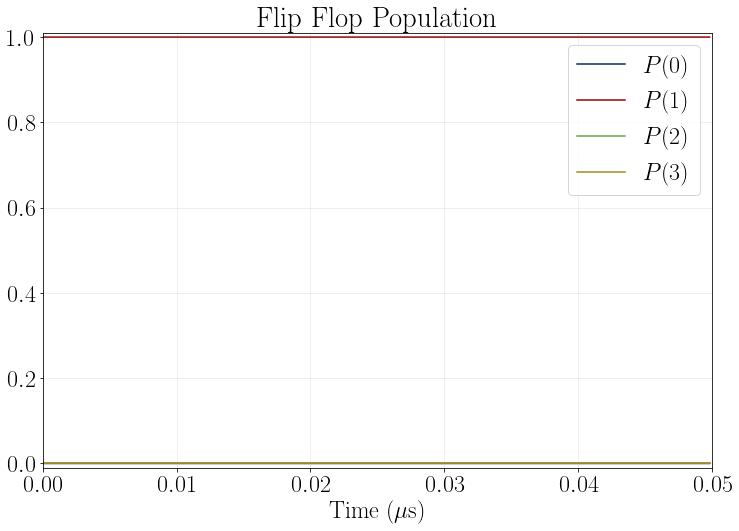

In [8]:
fig=plt.figure(figsize=(12,8))
ax = fig.add_subplot(111)
for state in np.arange(4):
    ax.plot(t/1000,rho_ff[:,state,state], label=rf'$P({state})$', color=UBColors[state])
ax.set_xlabel(r'Time ($\mu$s)')
ax.set_ylabel('')
ax.set_title('Flip Flop Population')
plt.grid(alpha=0.25)
ax.set_xlim([0,T_Max/1000])
ax.set_ylim([-0.01,1.01])
plt.legend(loc=0)
timeString = datetime.datetime.now().strftime('%Y%m%d%H%M%S')
fileName = '1q1p0n_FlipFlopPopulation_'+timeString+'.png'
plt.savefig('_figures/'+fileName,dpi=600)
plt.show()
with open('_figures/Exp_Parameters.csv','a+') as f:
    f.write(f"{fileName},{Nd},{Np},False,{parameters_qubits[0]['eps']},{parameters_qubits[0]['wB']},{parameters_qubits[0]['Vt']},{parameters_cavity[0]['wc']},{parameters_cavity[0]['gc']}\n")

Comparing the cavity occupation plots for different values of the cavity energy, $\omega_c$, we can see that for larger cavity energies, we can neglect values of $N_p>1$ if $g_c$ is sufficiently small since the photon in the singly occupied state is quickly annihilated to return back to the vaccum state.

## Two Donor, One Photon
Now we want to check for multi-qubit coupling mediated by this cavity. We've also seen that it should be possible in the effective Hamiltonian.
$$
H_{2q} = \hbar \omega_c a^\dagger a + \sum_i\sum_j E_{ij} \ket{j}_i\bra{j}_i + \sum_i\frac{1}{2}g_c(a+a^\dagger)(1+Z_i)
$$

In [22]:
N_d = 2  # Number of donor qubits
N_p = 1
initial_cavity_state = np.zeros((N_p+1,1))
initial_cavity_state[0,:] = 1
initial_flipflop_state = np.array([[0,1,0,0,
                                    0,0,0,0,
                                    0,0,0,0,
                                    0,0,0,0]]).transpose()
initial_flipflop_state = initial_flipflop_state / np.linalg.norm(initial_flipflop_state)
initial_total_state = np.kron(initial_cavity_state,initial_flipflop_state)
wc = 11.4 # GHz, TODO: Find actual value for this
gc = 0.3 # GHz, TODO: Find actual value for this
parameters_qubits = []
for _ in np.arange(N_d):
    parameters_qubits.append({'Vt':11.4, 'wB':11.3, 'eps':0})
parameters_cavity = {'wc': wc , 'gc':gc}
N_t = 1000
T_Max = 100000
t, rho_ff, rho_cav = computeDensityMatrixZeroNoise(initial_total_state , N_t, T_Max, N_d, parameters_qubits, N_p, parameters_cavity)
print(rho_ff.shape)
print(rho_cav.shape)

<ipython-input-2-1d7401ef66b3>:65: ComplexWarning: Casting complex values to real discards the imaginary part
  eiwt[i].flat[slice(0,None,1+N_dims**2)] = eiwtList[i]
(1000, 16, 16)
(1000, 2, 2)


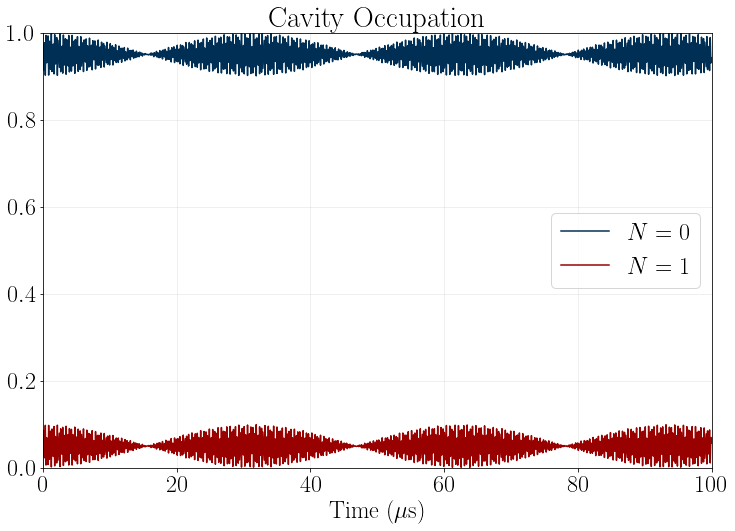

In [23]:
fig, ax = plt.subplots(figsize=(12,8))
for occ in np.arange(N_p+1):
    ax.plot(t/1000,rho_cav[:,occ,occ], label=rf'$N = {occ}$', color = UBColors[occ])
ax.set_xlabel(r'Time ($\mu$s)')
ax.set_ylabel('')
ax.set_title('Cavity Occupation')
plt.grid(alpha=0.25)
ax.set_xlim([0,T_Max/1000])
ax.set_ylim([0,1])
plt.legend(loc=0)
timeString = datetime.datetime.now().strftime('%Y%m%d%H%M%S')
fileName = '2q1p0n_PhotonPopulation_'+timeString+'.png'
plt.savefig('_figures/'+fileName,dpi=600)
plt.show()
with open('_figures/Exp_Parameters.csv','a+') as f:
    f.write(f"{fileName},{N_d},1,False,[{parameters_qubits[0]['eps']};{parameters_qubits[1]['eps']}],[{parameters_qubits[0]['wB']};{parameters_qubits[1]['wB']}],[{parameters_qubits[0]['Vt']};{parameters_qubits[1]['Vt']}],{parameters_cavity['wc']},{parameters_cavity['gc']}\n")

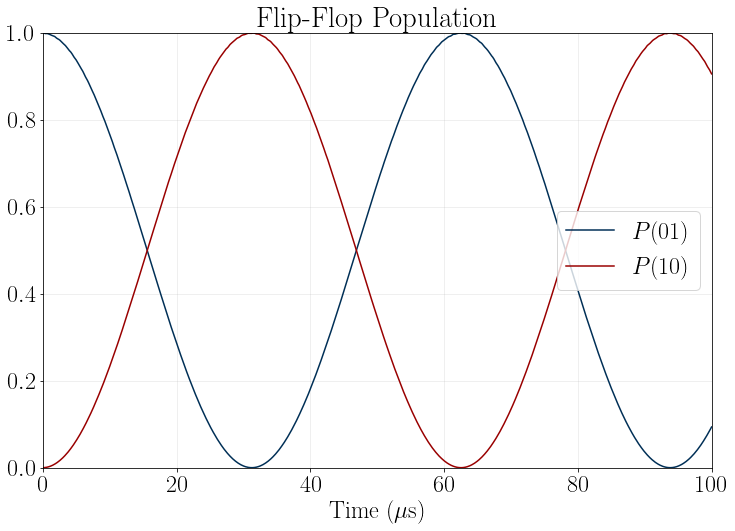

In [24]:
fig, ax = plt.subplots(figsize=(12,8))
for i,state in enumerate([1,4]):
    ax.plot(t/1000,rho_ff[:,state,state], label=rf'$P({state//4}{state%4})$', color=UBColors[i])
# ax.plot(t/1000,rho_ff[:,1,1], label=r'$P_{01}$',color=UBColors[0])
# ax.plot(t/1000,rho_ff[:,4,4], label=r'$P_{10}$',color=UBColors[1])
ax.set_xlabel(r'Time ($\mu$s)')
ax.set_ylabel('')
ax.set_title('Flip-Flop Population')
plt.legend(loc=0)
plt.grid(alpha=0.25)
ax.set_xlim([0,T_Max/1000])
ax.set_ylim([0,1])

timeString = datetime.datetime.now().strftime('%Y%m%d%H%M%S')
fileName = '2q1p0n_FlipFlopPopulation_'+timeString+'.png'
plt.savefig('_figures/'+fileName,dpi=600)
plt.show()
with open('_figures/Exp_Parameters.csv','a+') as f:
    f.write(f"{fileName},{N_d},{N_p},False,[{parameters_qubits[0]['eps']};{parameters_qubits[1]['eps']}],[{parameters_qubits[0]['wB']};{parameters_qubits[1]['wB']}],[{parameters_qubits[0]['Vt']};{parameters_qubits[1]['Vt']}],{parameters_cavity['wc']},{parameters_cavity['gc']}\n")